In [321]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as sLA

from IPython.display import Image
from IPython.display import display, Latex

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from matplotlib import style
# style.use('ggplot')

In [322]:
from scipy import linalg as sLA
from scipy.special import hermite, factorial
from scipy.integrate import quad
from scipy.stats import chi2, chisquare
from scipy import interpolate
from tqdm import tqdm

In [323]:
#Вычисление Фиделити для векторов чистых состояний
def Fidelity_pure(vec0, vec1):
    return np.abs(np.dot(vec0, vec1.conjugate())) ** 2

# Функция для отрисовки 3-D barchart
def plot_matrix(m, title = 'Входное состояние'):
    
    style.use('ggplot')

    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111, projection='3d')
    
    xi = np.reshape(list(np.arange(m.shape[0]))*m.shape[1], (-1))
    yi = np.reshape(np.reshape((list(np.arange(m.shape[1]))*m.shape[0]), (m.shape[1], m.shape[0])).T, (-1))
    z0 = np.zeros(m.shape[0]*m.shape[1])
    
    dx = np.ones(m.shape[0]*m.shape[1])
    dy = np.ones(m.shape[1]*m.shape[0])
    dz = np.reshape(m, (-1))
    
    ax1.bar3d(xi, yi, z0, dx, dy, dz, shade=True)


    ax1.set_xlabel('Колличество фотонов во втором канале n2')
    ax1.set_ylabel('Колличество фотонов в первом канале n1')
    ax1.set_zlabel('Вероятность p1p2')
    ax1.set_title(title)

    plt.show()

# Пункт 1:
### Зададим состояниее согласно 3-му варианту и определим для него фоковское пространство, достаточное для представленияя с точностью $10^{-6}$

Вариант 3:

Рассматриваемое состояние:

$\phi ~ | \alpha \rangle + |1 \rangle$, где $\alpha = 0.9i$ =>

$\phi =  (|1 \rangle + e^{\frac{-|\alpha|^2}{2}} \sum_{n=0}^{n_{max}} \frac{\alpha^{n}}{\sqrt{n!}} |n\rangle) /  norm$, где $n = 0.9i$

In [324]:
# Создаёт когерентное состояние
def get_rho_coherent(N, d, alpha = 0.9*1j):
    n = np.arange(N)
    fact_n = np.array([np.math.factorial(x) for x in n]).astype(float)
    state = np.exp((-np.abs(alpha) ** 2) / 2) * (alpha ** n) / np.sqrt(fact_n)
    rho = np.outer(state,state.conjugate())
    
    rho_full = np.zeros((d,d))
    rho_full[:N,:N] = rho
    return rho_full, state


def get_coherent_probs(n, alpha = 0.9*1j):
    return np.exp((-np.abs(alpha) ** 2)) * (np.abs(alpha) ** (2*n)) / float(np.math.factorial(n))

def get_coherent_coefs(n, alpha = 0.9*1j):
    return np.exp((-np.abs(alpha) ** 2) / 2) * (alpha ** (2*n)) / np.sqrt(float(np.math.factorial(n)))
    
# Расчитывает ошибку ограничения размерности рассматриваемой системы
def restrictions_err(N, func = get_coherent_probs):
    return 1 - sum([func(i) for i in range(N)])

def get_my_state(N, d):
    _, state = get_rho_coherent(N, d, alpha = 0.9*1j)
    state1 = np.zeros(len(state))
    state1[1] = 1
    state += state1
    norm_coef = np.sqrt(state@state.conj())
    
    state = state/norm_coef
    rho = np.outer(state,state.conjugate())
    
    rho_full = np.zeros((d,d))
    rho_full[:N,:N] = rho
    return rho, state

Заданное состояние является суперпозицией фоковского и когерентного. При этом фоковское cостояние $|1 \rangle$ представляется точно в рассматриваемом фоковском пространнстве $n>=1$.
Будем следить только за точностью представления когерентного состояния.

Найдём размерность достаточную для представления когерентного состояния с точностью $10^{-6}$

In [325]:
print('Ошибка в распределении за счёт сокращения размерности до 8:', restrictions_err(8))
print('Ошибка в распределении за счёт сокращения размерности до 9:', restrictions_err(9))

Ошибка в распределении за счёт сокращения размерности до 8: 2.244554789920805e-06
Ошибка в распределении за счёт сокращения размерности до 9: 2.0008311862884653e-07


Достаточно рассмотреть фоковское пространство размерностью 9

In [326]:
N = 9
# Получим заданное состояние
my_rho, my_state = get_my_state(N, N)

# Определим массив коэфициентов cn при соответствующих состояниях |n>
cn_list = my_state

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part



# Пункт 2:
#### Зададим состояние через разложение на полиномы Эрмита

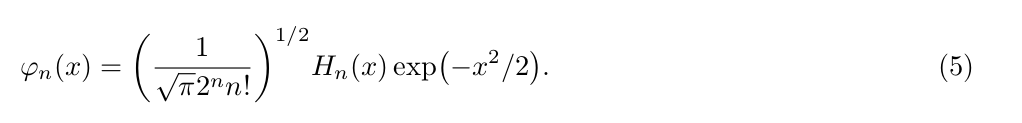

In [327]:
from IPython.display import Image
Image(filename='pics/Chebyshev_hermit_basis.png')

Также учтём зависимость от фазы

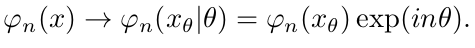

In [328]:
Image(filename='pics/psi_theta.png')

И окончательно получим состояние через найденные пункте 1 коэффициенты $c_n$

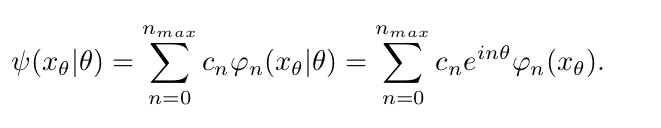

In [329]:
Image(filename='pics/state.png')

In [330]:
def phi_theta(n, x, theta):
    return (1/(np.pi**0.5*2**n*factorial(n)))**(1/2)*hermite(n)(x)*np.exp(-x**2/2)*np.exp(1j*n*theta)

def get_theor_state(cn_list, N, x, theta):
    return np.sum(np.array([cn_list[i]*phi_theta(i, x, theta) for i in range(N)]), axis = 0)
    
def get_probs(state):
    return abs(state)**2

# Более быстрая функция для вероятности. Понадобится при решении УП
def p_(phi_theta, psi):
    return abs(np.tensordot(psi, phi_theta, axes=1))**2

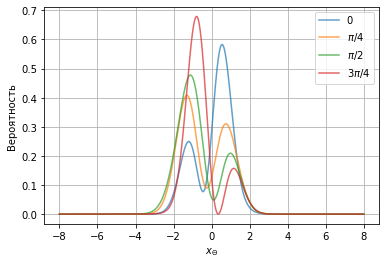

In [331]:
x_list = np.linspace(-8, 8, 1000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']

for theta, theta_label in zip(thetas, thetas_label):
    p_list = get_probs(get_theor_state(cn_list, N, x_list, theta))
    plt.plot(x_list, p_list, '-', alpha=0.7, label=theta_label)
plt.xlabel('$x_\Theta$')
plt.ylabel('Вероятность')
plt.legend()
plt.grid()
plt.show()

# Пункт 3:
#### Выполним симуляцию измерений для каждого значения $\theta$

In [332]:
def F(z, x_list, state):
    return np.trapz(get_probs(state)[x_list <= z], x_list[x_list <= z])

In [333]:
n = 10000
L = 10
inv_points = 100



x_list = np.linspace(-L, L, inv_points)

thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']

Func_list = []
x_rec_list = []

for theta in thetas:
    y = []
    state = get_theor_state(cn_list, N, x_list, theta)
    for x_inv in tqdm(x_list):
        y.append(F(x_inv, x_list, state))
                 
    # Восстановим функцию распределения
    F_inv = interpolate.interp1d(y, x_list, fill_value=(0, 1), bounds_error=False)
    Func_list.append(F_inv)
    
    # Из восстановленной ф-ии распределения сгенерируем 1000 случайных величин
    # Каждое соответствует измерению
    y_random = np.random.rand(n)
    x_reconstructed = F_inv(y_random)
    x_rec_list.append(x_reconstructed)
    

100%|██████████| 100/100 [00:00<00:00, 10899.96it/s]


#### Построим соответствующие распределения

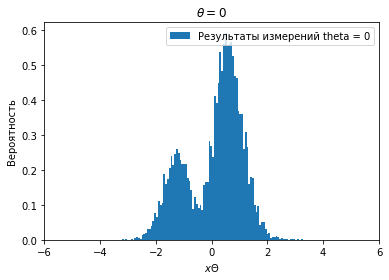

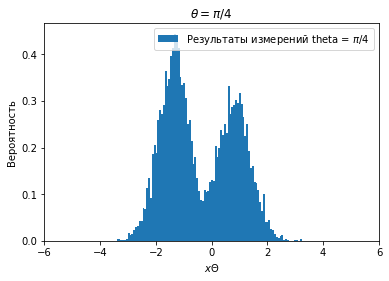

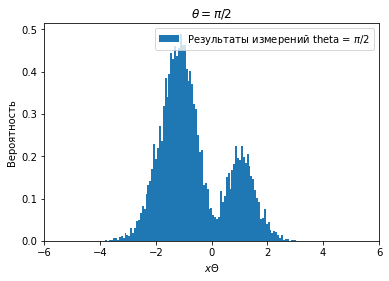

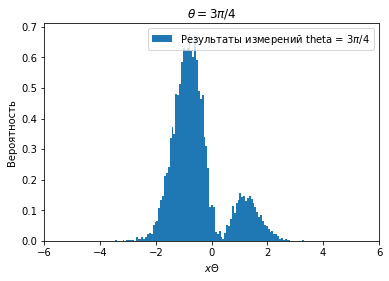

In [334]:
for x_rec, theta_label in zip(x_rec_list, thetas_label):   
    plt.hist(x_rec, bins=100, density=True, label=f'Результаты измерений theta = {theta_label}')
    plt.xlabel('$x \Theta$')
    plt.ylabel('Вероятность')
    plt.title(r'$\theta = $' + f'{theta_label}')
    plt.xlim(-6, 6)
    plt.legend()
    plt.show()

# Пункт 4:

#### Проведём реконструкцию состояния методом MLE

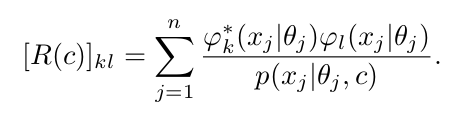

In [335]:
Image(filename='pics/R_matrix.png')

Создадим полный набор $(x_j, \theta_j)$

In [336]:
len(x_rec_list[0])

10000

In [337]:
# Полный набор измерений состоит из 4000 измерений по 4000 на каждую theta
x_rec_list = np.array(x_rec_list)

thetas_list = []
for theta in thetas:
    thetas_list.append([theta]*x_rec_list.shape[1])
    
thetas_list = np.array(thetas_list)


In [338]:
# Зададим функцию собирающую матрицу R(c)

# Заметим, что числители дробей в сумме выше не зависят от c. 
# Посчитаем их заранее, чтобы не пересчитывать на каждой итерации далее


def get_R_numerators(N = 9, thetas = thetas, x_rec_list = x_rec_list):
    psi_n_list = []
    for n in range(N):
        psi = []
        for theta, x in zip(thetas, x_rec_list):       
            psi.append(phi_theta(n, x, theta))
        psi = np.array(psi).flatten()
        psi_n_list.append(psi)
    
    numerators_list = np.reshape([psi1.conj()*psi2 for psi1 in psi_n_list for psi2 in  psi_n_list], (9,9,40000))                       
    return np.array(numerators_list).T

numerators_list = get_R_numerators()

In [339]:
def get_R(c, numerators_list):
    denumerators_list = []
    for theta, x in zip(thetas, x_rec_list):
        state = get_theor_state(c, N, x, theta)
        p = get_probs(state)
        denumerators_list.append(p)
        
    denumerators_list = np.array(denumerators_list).flatten()
    return np.sum(numerators_list/np.reshape(denumerators_list, (40000, 1, 1)), axis = 0).T
    
    

In [340]:
# Проверим работу ф-ии
c = np.random.randn(9)
c = c/np.sqrt(c**2)
R = get_R(c, numerators_list)
print(R)

[[ 33050960.49548192+0.00000000e+00j  28413912.5373168 -3.23583567e+03j
     983735.08023671-7.73769031e+01j -12860178.75399077+1.26015439e+03j
   -2156337.29892262-1.28228650e-12j   6168699.50732652+5.61076018e+02j
   -2051143.33170204+1.34777086e+03j  -6355095.26077142-3.78475282e+02j
    4819121.7908384 +2.26656831e-12j]
 [ 28413912.5373168 +3.23583567e+03j  34441845.38766157+0.00000000e+00j
   17897618.48490906-1.27450405e+03j  -2619392.41188923+1.87139089e+03j
  -11926726.07682998+1.26570467e+03j  -9859944.44005159+2.11166880e-12j
   -1699651.07222234+1.48169050e+03j   8213656.6625741 -3.78276333e+02j
   11265683.79833854-1.27012299e+03j]
 [   983735.08023671+7.73769031e+01j  17897618.48490906+1.27450405e+03j
   30530377.98236234+0.00000000e+00j  14145223.7845127 -6.97785984e+02j
  -17762453.50116404+2.62732568e+02j -26163620.98081426-1.68367775e+02j
    -257999.23107358+1.97542430e-13j  23855192.29857524+1.23169627e+02j
   12970618.07268413-6.38034344e+01j]
 [-12860178.75399077-1

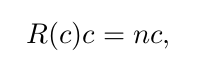

In [341]:
Image(filename='pics/iter_method.png')

In [ ]:
%%time

eps = 1e-8
mu=0.5

# Зададим случайное чистое состояние в качестве начального приближения
c = np.random.randn(9)
c = c/np.sqrt(c**2)

for i in tqdm(range(1000)):
    c_prev = c
    c = (1-mu)*get_R(c_prev, numerators_list) @ c_prev/ 40000 + mu*c_prev
    print(np.sum(abs(c_prev - c)**2)**0.5)
    if np.sum(abs(c_prev - c)**2)**0.5 < eps:
        break
    
    


  0%|          | 1/1000 [00:00<02:18,  7.21it/s]

1.3642155442443105


  0%|          | 2/1000 [00:00<02:33,  6.52it/s]

0.637510725278479


  0%|          | 3/1000 [00:00<02:28,  6.73it/s]

0.33228336624033034


  0%|          | 4/1000 [00:00<02:22,  6.97it/s]

0.17151939607522745


  0%|          | 5/1000 [00:00<02:20,  7.07it/s]

0.10088806853036636


  1%|          | 6/1000 [00:00<02:24,  6.87it/s]

0.08061690308282872


  1%|          | 7/1000 [00:01<02:30,  6.59it/s]

0.06917512496694198


  1%|          | 8/1000 [00:01<02:29,  6.64it/s]

0.05952379610989506


  1%|          | 9/1000 [00:01<02:30,  6.60it/s]

0.050273247219445365


  1%|          | 10/1000 [00:01<02:32,  6.50it/s]

0.04097627300243435


  1%|          | 11/1000 [00:01<02:27,  6.71it/s]

0.03535606573254021


  1%|          | 12/1000 [00:01<02:17,  7.19it/s]

0.036052717620500996


  1%|▏         | 13/1000 [00:01<02:10,  7.58it/s]

0.048444195450184746


  1%|▏         | 14/1000 [00:02<02:11,  7.51it/s]

0.03793545533796147


  2%|▏         | 15/1000 [00:02<02:18,  7.11it/s]

0.03900765597507525


  2%|▏         | 16/1000 [00:02<02:23,  6.85it/s]

0.0420016960420446


  2%|▏         | 17/1000 [00:02<02:25,  6.75it/s]

0.045938656729641265


  2%|▏         | 18/1000 [00:02<02:22,  6.90it/s]

0.05046176813162618


  2%|▏         | 19/1000 [00:02<02:19,  7.06it/s]

0.05546238794334615


  2%|▏         | 20/1000 [00:02<02:17,  7.13it/s]

0.06016852273225597


  2%|▏         | 21/1000 [00:03<02:23,  6.81it/s]

0.0636986764563808


  2%|▏         | 22/1000 [00:03<02:17,  7.09it/s]

0.06625854755870648


  2%|▏         | 23/1000 [00:03<02:08,  7.60it/s]

0.06798531626785662


  2%|▏         | 24/1000 [00:03<02:11,  7.41it/s]

0.06925185758124797


  2%|▎         | 25/1000 [00:03<02:11,  7.44it/s]

0.07027395915065084


  3%|▎         | 26/1000 [00:03<02:10,  7.47it/s]

0.07100504247695755


  3%|▎         | 27/1000 [00:03<02:09,  7.49it/s]

0.07116807336329903


  3%|▎         | 28/1000 [00:03<02:09,  7.49it/s]

0.07049268750108623


  3%|▎         | 29/1000 [00:04<02:10,  7.46it/s]

0.07877785044810502


  3%|▎         | 30/1000 [00:04<02:10,  7.45it/s]

0.06869690681013155


  3%|▎         | 31/1000 [00:04<02:10,  7.42it/s]

0.06265593327234341


  3%|▎         | 32/1000 [00:04<02:08,  7.51it/s]

0.05562077525442271


  3%|▎         | 33/1000 [00:04<02:02,  7.88it/s]

0.048131553529256334


  3%|▎         | 34/1000 [00:04<01:56,  8.27it/s]

0.04015558592548078


  4%|▎         | 35/1000 [00:04<01:51,  8.64it/s]

0.03264720419656343


  4%|▎         | 36/1000 [00:04<01:48,  8.88it/s]

0.026130095028080634


  4%|▎         | 37/1000 [00:05<01:47,  9.00it/s]

0.020800139107761656


  4%|▍         | 38/1000 [00:05<01:45,  9.08it/s]

0.016692293877604653


  4%|▍         | 39/1000 [00:05<01:44,  9.20it/s]

0.01379727103608812


  4%|▍         | 40/1000 [00:05<01:43,  9.31it/s]

0.012132141524011496


  4%|▍         | 41/1000 [00:05<01:43,  9.30it/s]

0.011473563312887439


  4%|▍         | 42/1000 [00:05<01:43,  9.22it/s]

0.010953958629503312


  4%|▍         | 43/1000 [00:05<01:43,  9.25it/s]

0.00991517338725208


  4%|▍         | 44/1000 [00:05<01:42,  9.36it/s]

0.008458893785964402


  4%|▍         | 45/1000 [00:05<01:46,  8.99it/s]

0.0068774736745713695


  5%|▍         | 46/1000 [00:06<01:44,  9.15it/s]

0.005385338020278655


  5%|▍         | 47/1000 [00:06<01:41,  9.35it/s]

0.00410027379746595


  5%|▍         | 48/1000 [00:06<01:41,  9.33it/s]

0.003065028341163864


  5%|▍         | 49/1000 [00:06<01:42,  9.30it/s]

0.002270846253536647


  5%|▌         | 50/1000 [00:06<01:42,  9.30it/s]

0.001681616778057827


  5%|▌         | 51/1000 [00:06<01:42,  9.26it/s]

0.0012532485245584722


  5%|▌         | 52/1000 [00:06<01:41,  9.30it/s]

0.0009447961151565409


  5%|▌         | 53/1000 [00:06<01:41,  9.33it/s]

0.0007228357627554239


  5%|▌         | 54/1000 [00:06<01:40,  9.37it/s]

0.0005620209082586654


  6%|▌         | 55/1000 [00:06<01:40,  9.41it/s]

0.00044400530739449243


  6%|▌         | 56/1000 [00:07<01:40,  9.41it/s]

0.00035591546719274277


  6%|▌         | 57/1000 [00:07<01:40,  9.35it/s]

0.0002888969970536931


  6%|▌         | 58/1000 [00:07<01:40,  9.35it/s]

0.00023692254500597918


  6%|▌         | 59/1000 [00:07<01:40,  9.37it/s]

0.00019589362772222112


  6%|▌         | 60/1000 [00:07<01:41,  9.30it/s]

0.00016300216883876492


  6%|▌         | 61/1000 [00:07<01:43,  9.11it/s]

0.00013629527664076486


  6%|▌         | 62/1000 [00:07<01:48,  8.67it/s]

0.00011438694513771611


  6%|▋         | 63/1000 [00:07<01:45,  8.88it/s]

9.627027368334405e-05


  6%|▋         | 64/1000 [00:07<01:43,  9.06it/s]

8.119593818368849e-05


  6%|▋         | 65/1000 [00:08<01:42,  9.09it/s]

6.859332972062867e-05


  7%|▋         | 66/1000 [00:08<01:42,  9.09it/s]

5.801885336835152e-05


  7%|▋         | 67/1000 [00:08<01:44,  8.93it/s]

In [ ]:
n_list = np.arange(9)

plt.bar(n_list-0.1, abs(c)**2, alpha=0.5, width=0.5, label='Реконструкция')
plt.bar(n_list+0.1, abs(cn_list)**2, alpha=0.5, width=0.5, label='Реальное состояние')
plt.xticks(n_list)
plt.xlim(-1, 10)
plt.xlabel('Число фотонов')
plt.ylabel('Вероятность')
plt.legend()
plt.show()

In [ ]:
# Рассчитаем Fidelity между реконструкцией и реальным состоянием
Fidelity_pure(c, cn_list)

Состояния совпадаяют с высокой точностью

# Пункт 4:

#### Построим распределения для различных $\theta$

In [ ]:
x_list = np.linspace(-8, 8, 1000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']


for x, theta, theta_label in zip(x_rec_list, thetas, thetas_label):
    
    plt.hist(x, density = True, bins = 50, alpha = 0.3, label = 'Статистика моделирования измерений')
    
    p_list = get_probs(get_theor_state(cn_list, N, x_list, theta))
    plt.plot(x_list, p_list, '-', linewidth = 3, alpha=0.7, label='Реальное состояние')
    
    p_list = get_probs(get_theor_state(c, N, x_list, theta))
    plt.plot(x_list, p_list, '-.', linewidth = 2, alpha=0.7, label='Реконструкция')
    
    plt.title(f'Theta = {theta}')
    plt.xlabel('$x_\Theta$')
    plt.ylabel('Вероятность')
    plt.legend(loc='upper left')
    plt.grid()
    
    plt.show()
    
    

# Пункт 6:

#### Вычислим p-value для всех $\theta$

In [ ]:
Image(filename='pics/Chi2.png')

In [ ]:
# Разобьём данные по квантилям, чтобы в один бин не попадало менее 5-ти измерений
n_bins = 10
nt = 10000



E_list = []
O_list = []

for x, theta in zip(x_rec_list, thetas):
    x = np.array(sorted(x))
#     x_bins = np.quantile(x, np.linspace(0,1,n_bins+1))
    x_bins = np.linspace(x.min(), x.max(), n_bins+1)
#     x_bins[0] -= 1
    x_bin_prev = x_bins[0]
#     x_bins[-1] += 1
    for x_bin in x_bins[1:]:
        x_vals = x[(x<x_bin) & (x>x_bin_prev)]
        O = len(x_vals)
        E = nt * np.trapz(get_probs(get_theor_state(c, N, x_vals, theta)), x_vals)
        E_list.append(E)
        O_list.append(O)
        
        x_bin_prev = x_bin
        
O_list = np.array(O_list)
E_list = np.array(E_list)

Xi2 = np.sum((O_list - E_list)**2/E_list)

In [ ]:
print(f'nt = {nt}')
print(f'sum(E_list) для соответствующих theta = {np.sum(np.reshape(E_list, (4, n_bins)), axis = 1)}')

In [ ]:
nu = 4*n_bins - len(thetas) - 2*(N - 1) - 1
p_value = 1 - chi2.cdf(Xi2.real, nu)
print('p-value = ' + str(p_value))

Для визуализации разобьём на меньшее количество бинов (n_bins = 10)

In [ ]:
# Разобьём данные по квантилям, чтобы в один бин не попадало менее 5-ти измерений
n_bins = 10
nt = 10000

E_list = []
O_list = []

for x, theta in zip(x_rec_list, thetas):
    x = np.array(sorted(x))
#     x_bins = np.quantile(x, np.linspace(0,1,n_bins+1))
    x_bins = np.linspace(x.min(), x.max(), n_bins+1)
#     x_bins[0] -= 1
    x_bin_prev = x.min()
#     x_bins[-1] += 1
    
    for x_bin in x_bins[1:]:
        x_vals = x[(x<x_bin) & (x>x_bin_prev)]
        O = len(x_vals)
        E = nt * np.trapz(get_probs(get_theor_state(c, N, x_vals, theta)), x_vals)
        E_list.append(E)
        O_list.append(O)
        
        x_bin_prev = x_bin
        
O_list = np.array(O_list)
E_list = np.array(E_list)

Xi2 = np.sum((O_list - E_list)**2/E_list)

In [ ]:
n_list = np.arange(E_list.shape[0])

plt.bar(n_list-0.1, E_list, alpha=0.5, width=0.5, label='Теоретическое значение')
plt.bar(n_list+0.1, O_list, alpha=0.5, width=0.5, label='Колличество наблюдений в бине')
plt.xticks(n_list[0::2])
plt.xlim(-1, E_list.shape[0])
plt.xlabel('Число фотонов')
plt.ylabel('Вероятность')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
x_bins